In [1]:
from os.path  import join
import struct
from array import array
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)  

# Set file paths based on added MNIST Datasets
training_images_filepath = 'data/mnist-dataset/train-images.idx3-ubyte'
training_labels_filepath = 'data/mnist-dataset/train-labels.idx1-ubyte'
test_images_filepath = 'data/mnist-dataset/t10k-images.idx3-ubyte'
test_labels_filepath = 'data/mnist-dataset/t10k-labels.idx1-ubyte'

In [3]:
# Load MINST dataset
print('Loading MNIST dataset...')
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()
print('MNIST dataset loaded.')

Loading MNIST dataset...
MNIST dataset loaded.


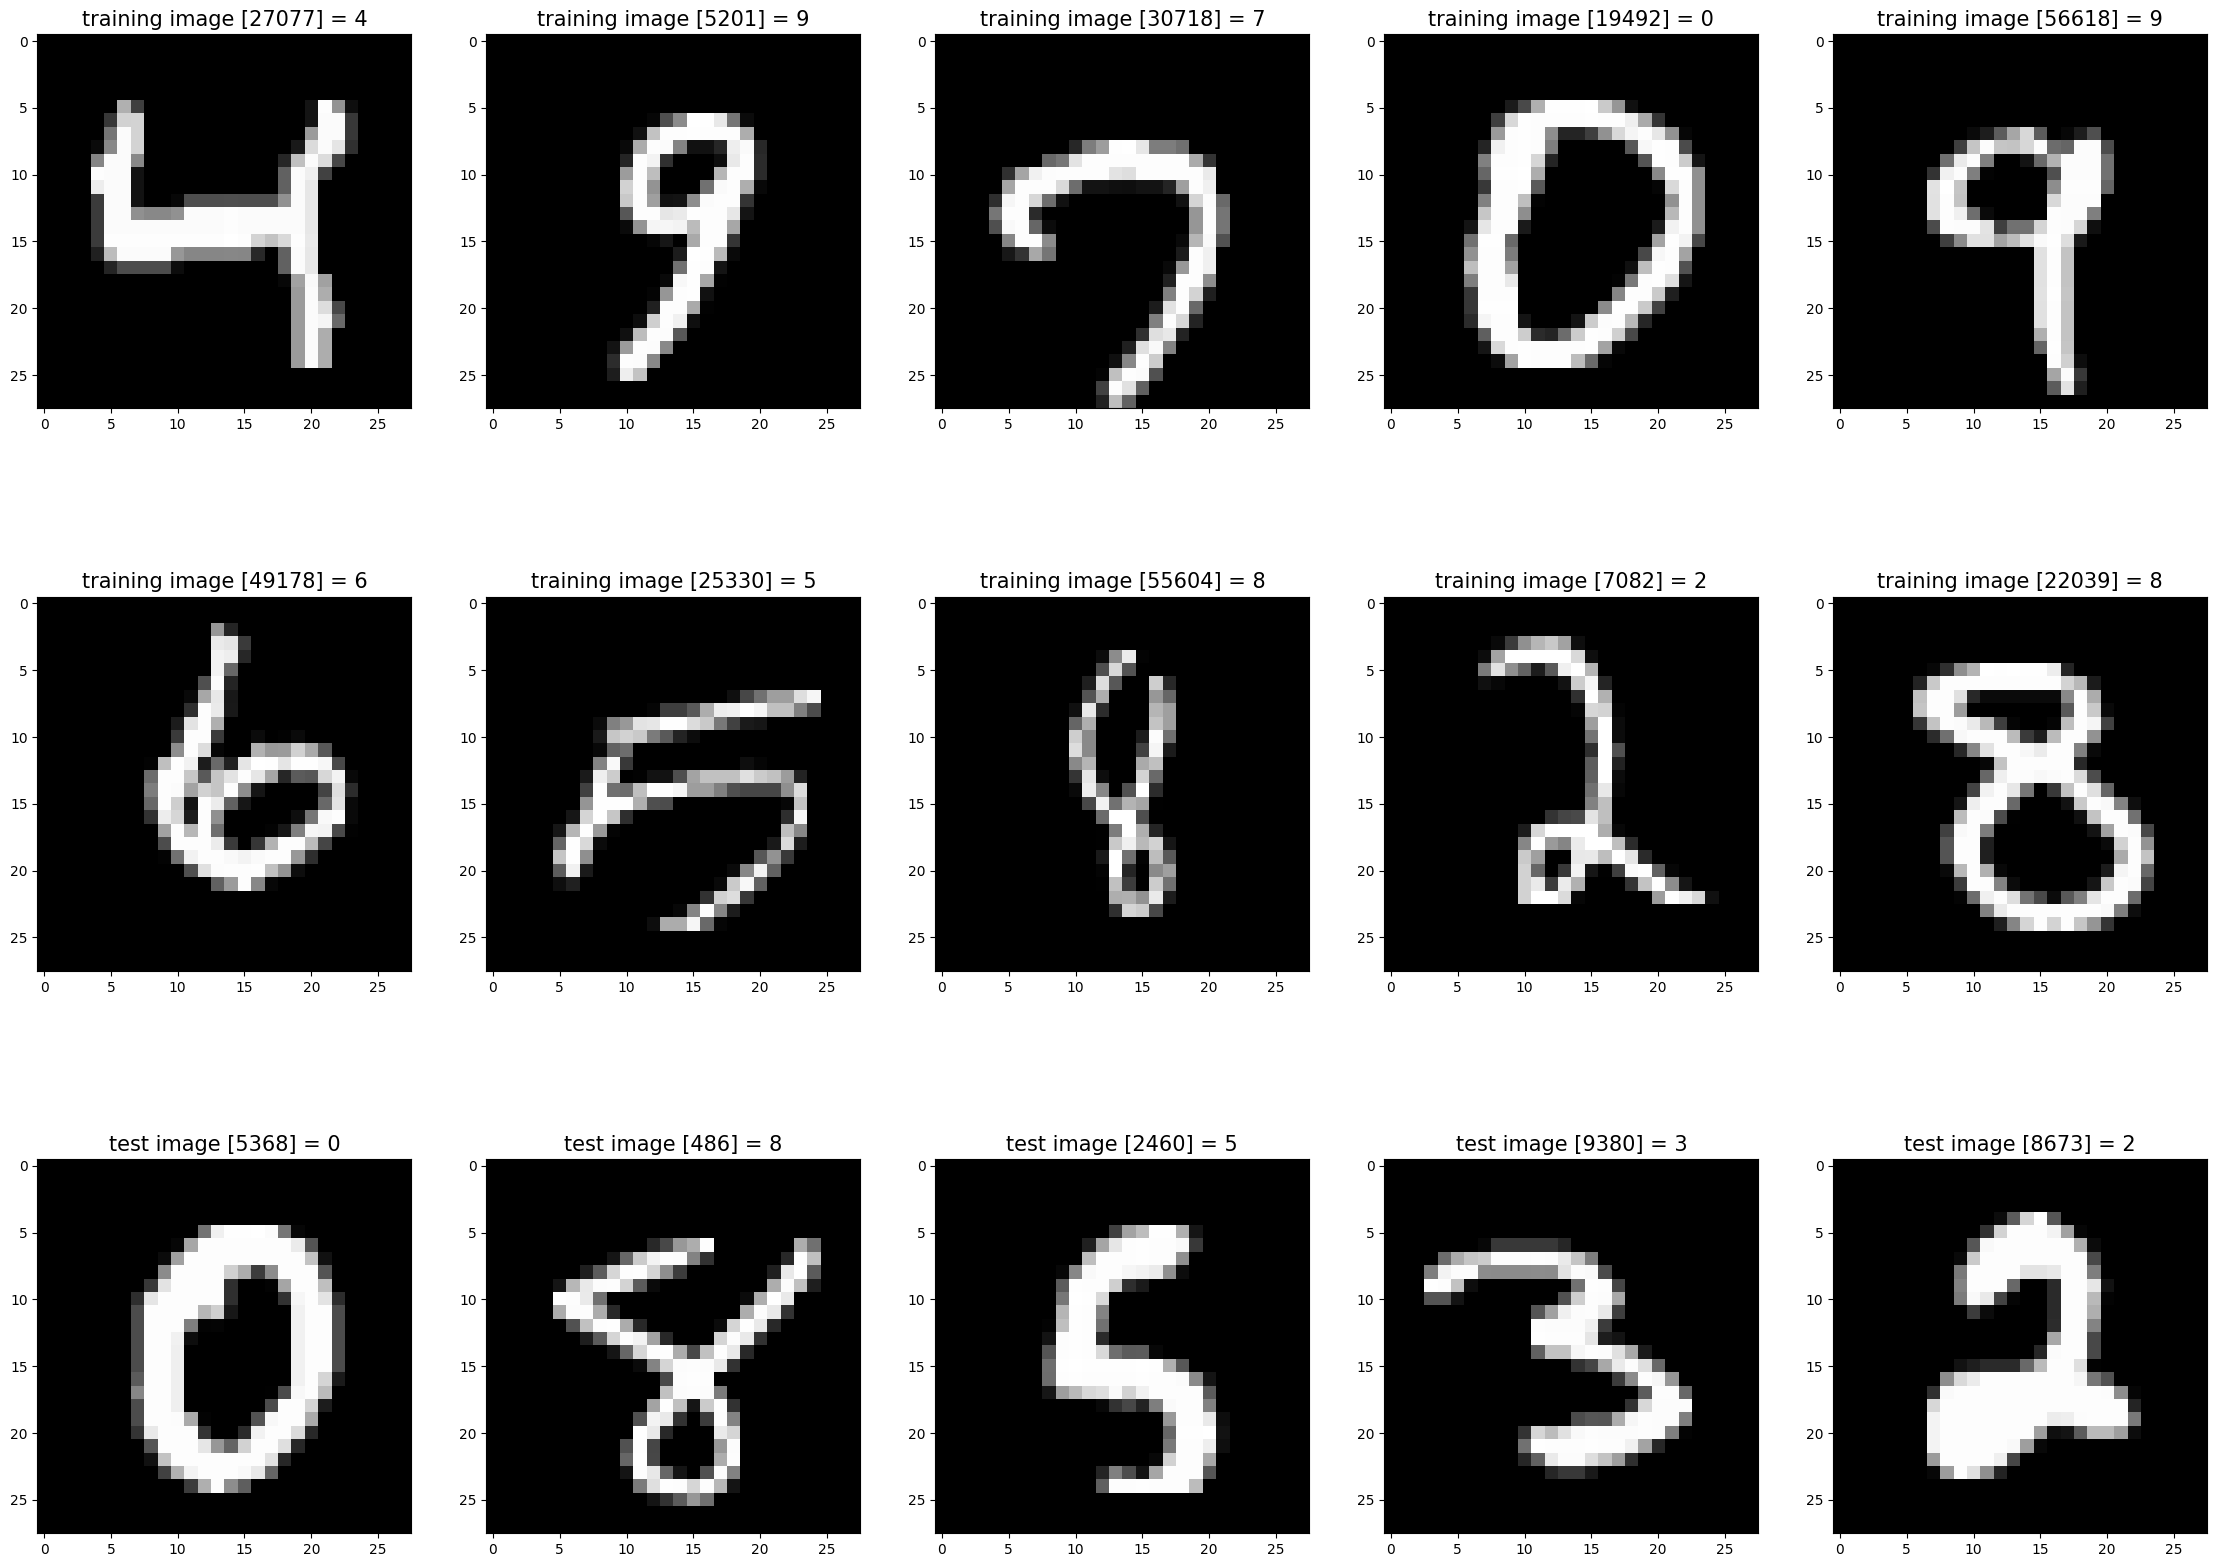

In [4]:
# Show example images
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(28, 28))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1

random_images = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    random_images.append((x_train[r], 'training image [' + str(r) + '] = ' + str(y_train[r])))
for i in range(0, 5):
    r = random.randint(1, 10000)
    random_images.append((x_test[r], 'test image [' + str(r) + '] = ' + str(y_test[r])))

show_images(list(map(lambda x: x[0], random_images)), list(map(lambda x: x[1], random_images)))

In [5]:
import torch
from torch.utils.data import TensorDataset, DataLoader

In [6]:
# Convert data to PyTorch tensors
train_images_tensor = torch.tensor(x_train, dtype=torch.float) / 255.0  # Normalize
train_labels_tensor = torch.tensor(y_train, dtype=torch.long)
test_images_tensor = torch.tensor(x_test, dtype=torch.float) / 255.0  # Normalize
test_labels_tensor = torch.tensor(y_test, dtype=torch.long)

# Create TensorDatasets
train_dataset = TensorDataset(train_images_tensor.unsqueeze(1), train_labels_tensor)  # Add channel dimension
test_dataset = TensorDataset(test_images_tensor.unsqueeze(1), test_labels_tensor)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

/var/folders/mj/4722r1qx7pl8pf9wggh8qvf80000gn/T/ipykernel_7741/1705458690.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1670525474122/work/torch/csrc/utils/tensor_new.cpp:233.)
  train_images_tensor = torch.tensor(x_train, dtype=torch.float) / 255.0  # Normalize


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class SmallResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(SmallResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.linear = nn.Linear(128*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


In [9]:
model = SmallResNet(BasicBlock, [2, 2])

if torch.backends.mps.is_available():
    print ("mps is available")
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

model = model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Training loop
for epoch in range(10):  # train for 10 epochs
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

# Testing loop - Calculate accuracy
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Accuracy of the model on the test images: {accuracy * 100:.2f}%')

mps is available
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.315179
Train Epoch: 0 [1600/60000 (3%)]	Loss: 0.710511
Train Epoch: 0 [3200/60000 (5%)]	Loss: 0.369036
Train Epoch: 0 [4800/60000 (8%)]	Loss: 0.316231
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.133522
Train Epoch: 0 [8000/60000 (13%)]	Loss: 0.090266
Train Epoch: 0 [9600/60000 (16%)]	Loss: 0.077578
Train Epoch: 0 [11200/60000 (19%)]	Loss: 0.211744
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.019059
Train Epoch: 0 [14400/60000 (24%)]	Loss: 0.579314
Train Epoch: 0 [16000/60000 (27%)]	Loss: 0.024559
Train Epoch: 0 [17600/60000 (29%)]	Loss: 0.104291
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.088740
Train Epoch: 0 [20800/60000 (35%)]	Loss: 0.040925
Train Epoch: 0 [22400/60000 (37%)]	Loss: 0.070101
Train Epoch: 0 [24000/60000 (40%)]	Loss: 0.054314
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.190118
Train Epoch: 0 [27200/60000 (45%)]	Loss: 0.033230
Train Epoch: 0 [28800/60000 (48%)]	Loss: 0.034721
Train Epoch: 0 [30400/60000 (51%)]	Loss: 0.1024

Train Epoch: 4 [20800/60000 (35%)]	Loss: 0.003058
Train Epoch: 4 [22400/60000 (37%)]	Loss: 0.005965
Train Epoch: 4 [24000/60000 (40%)]	Loss: 0.019325
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.001422
Train Epoch: 4 [27200/60000 (45%)]	Loss: 0.004748
Train Epoch: 4 [28800/60000 (48%)]	Loss: 0.003685
Train Epoch: 4 [30400/60000 (51%)]	Loss: 0.000662
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.000731
Train Epoch: 4 [33600/60000 (56%)]	Loss: 0.005833
Train Epoch: 4 [35200/60000 (59%)]	Loss: 0.007119
Train Epoch: 4 [36800/60000 (61%)]	Loss: 0.001696
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.004967
Train Epoch: 4 [40000/60000 (67%)]	Loss: 0.017582
Train Epoch: 4 [41600/60000 (69%)]	Loss: 0.164924
Train Epoch: 4 [43200/60000 (72%)]	Loss: 0.015367
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.071231
Train Epoch: 4 [46400/60000 (77%)]	Loss: 0.001171
Train Epoch: 4 [48000/60000 (80%)]	Loss: 0.043655
Train Epoch: 4 [49600/60000 (83%)]	Loss: 0.000937
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.007848


Train Epoch: 8 [41600/60000 (69%)]	Loss: 0.002748
Train Epoch: 8 [43200/60000 (72%)]	Loss: 0.043793
Train Epoch: 8 [44800/60000 (75%)]	Loss: 0.035329
Train Epoch: 8 [46400/60000 (77%)]	Loss: 0.002531
Train Epoch: 8 [48000/60000 (80%)]	Loss: 0.074679
Train Epoch: 8 [49600/60000 (83%)]	Loss: 0.000190
Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.000574
Train Epoch: 8 [52800/60000 (88%)]	Loss: 0.000155
Train Epoch: 8 [54400/60000 (91%)]	Loss: 0.006449
Train Epoch: 8 [56000/60000 (93%)]	Loss: 0.000890
Train Epoch: 8 [57600/60000 (96%)]	Loss: 0.000569
Train Epoch: 8 [59200/60000 (99%)]	Loss: 0.000548
Train Epoch: 9 [0/60000 (0%)]	Loss: 0.107720
Train Epoch: 9 [1600/60000 (3%)]	Loss: 0.022800
Train Epoch: 9 [3200/60000 (5%)]	Loss: 0.012069
Train Epoch: 9 [4800/60000 (8%)]	Loss: 0.000644
Train Epoch: 9 [6400/60000 (11%)]	Loss: 0.000272
Train Epoch: 9 [8000/60000 (13%)]	Loss: 0.027137
Train Epoch: 9 [9600/60000 (16%)]	Loss: 0.001096
Train Epoch: 9 [11200/60000 (19%)]	Loss: 0.006265
Train Epoch: 9